# SASA

## setup and data loading

In [25]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp, pearsonr, linregress

from dms_3d_features.plotting import plot_pop_avg_from_row, publication_style_ax, plot_motif_boxplot_stripplot
from dms_3d_features.pdb_features import compute_solvent_accessibility_all


In [26]:
def r2(x, y):
    return pearsonr(x, y)[0] ** 2

In [27]:
DATA_PATH = "../data"

In [28]:
df = pd.read_json(f"{DATA_PATH}/raw-jsons/residues/pdb_library_1_residues_pdb.json")
df_sasa = pd.read_csv(f"{DATA_PATH}/pdb-features/sasa.csv")
df_sasa["m_sequence"] = df_sasa["m_sequence"].apply(
        lambda x: x.replace("&", "_")
)

In [29]:
df.iloc[0]

m_sequence                                                       AAAC_GCU
r_nuc                                                                   A
pdb_r_pos                                                               3
r_type                                                                 WC
pdb_r_bp_type                                                         cWW
pdb_r_pair                                                            A-U
no_of_conformations                                                     1
no_of_interactions                                                      1
pdb_name                                   TWOWAY.6NY2.1-2.GCU-AAAC.0.pdb
pdb_path                data/pdbs/AAAC_GCU/TWOWAY.6NY2.1-2.GCU-AAAC.0.pdb
pdb_res                                                               3.2
both_purine                                                           0.0
both_pyrimidine                                                       0.0
constructs                            

In [30]:
df_sasa.iloc[0]

pdb_path      data/pdbs/ACCC_GACU/TWOWAY.3WBM.2-2.GACU-ACCC....
m_sequence                                            ACCC_GACU
r_nuc                                                         A
pdb_r_pos                                                     3
sasa_0_1                                                9.70854
sasa_0_25                                              7.511546
sasa_0_5                                                5.37142
sasa_1_5                                               2.673866
sasa_2_0                                               2.328213
sasa_2_5                                                2.71053
sasa_3_0                                               3.119972
Name: 0, dtype: object

In [31]:
df_merge = pd.merge(df, df_sasa, on=["m_sequence", "r_nuc", "pdb_r_pos", "pdb_path"])

In [32]:
df_merge = df_merge.query("not ln_r_data.isnull()")

## which SASA probe is best

In [33]:
sasa_columns = [c for c in df_merge.columns if "sasa" in c]
print(sasa_columns)

['sasa_0_1', 'sasa_0_25', 'sasa_0_5', 'sasa_1_5', 'sasa_2_0', 'sasa_2_5', 'sasa_3_0']


In [34]:
for c in sasa_columns:
    print(c, r2(df_merge[c], df_merge["ln_r_data"]))

sasa_0_1 0.19669012335603883
sasa_0_25 0.22853358817754255
sasa_0_5 0.22607328625755294
sasa_1_5 0.09259926293558056
sasa_2_0 0.0663380548443369
sasa_2_5 0.051142304568931866
sasa_3_0 0.04331012423667258


## Overall relationships between SASA and reactivity

<Axes: xlabel='sasa_0_5', ylabel='r_type'>

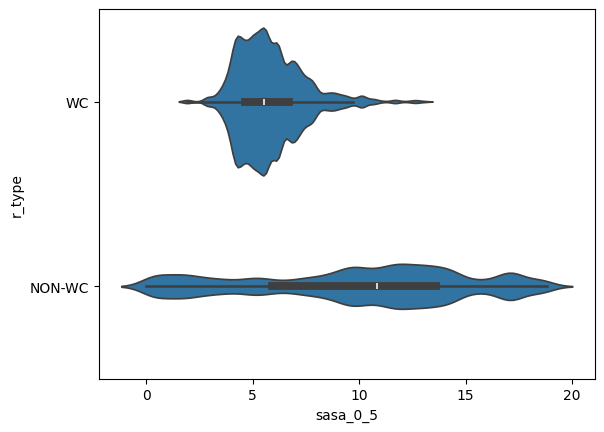

In [35]:
sns.violinplot(data=df_merge, x="sasa_0_5", y="r_type")

In [36]:
r2(df_merge["sasa_0_5"], df_merge["ln_r_data"])

0.22607328625755294

In [37]:
df_non_wc = df_merge.query("r_type == 'NON-WC'").copy()
df_wc = df_merge.query("r_type == 'WC'").copy()

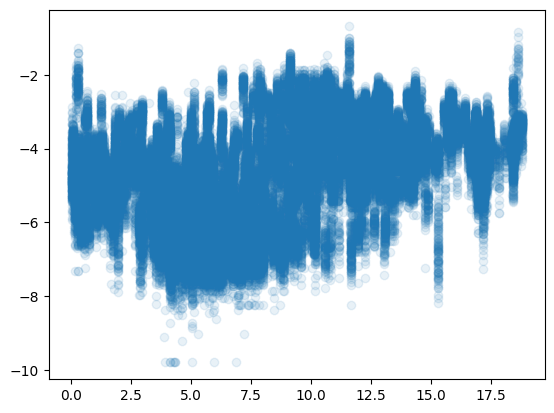

In [38]:
plt.scatter(df_merge["sasa_0_5"], df_merge["ln_r_data"], alpha=0.1)

In [39]:
data = [] 
for i, group in df_merge.groupby(["m_sequence", "r_loc_pos"]):
    data.append([group["r_data"].mean(), group["sasa_0_5"].mean()])
df_avg = pd.DataFrame(data, columns=["r_data", "sasa_0_5"])
df_avg["ln_r_data"] = np.log(df_avg["r_data"])
df_avg['ln_r_data'].replace(-np.inf, -9.8, inplace=True)


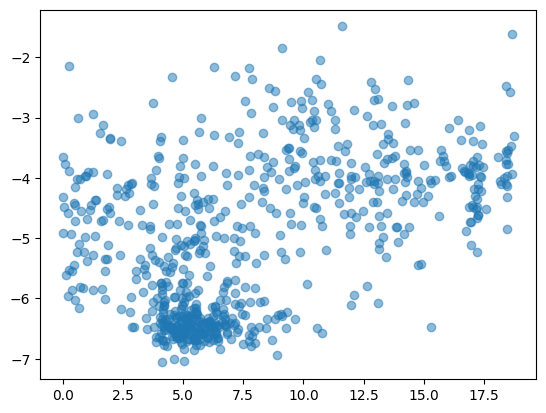

In [40]:
plt.scatter(df_avg["sasa_0_5"], df_avg["ln_r_data"], alpha=0.5)

## C-A / A-C pairs

In [75]:
df_sub = df_merge.query("r_type == 'NON-WC' and m_token == '1x1' and pdb_r_pair == 'C-A' and r_nuc == 'C'").copy()
for i, g in df_sub.groupby("m_sequence"):
    for j, group in g.groupby("pdb_path"):
        print(i, j, group.iloc[0]["pdb_name"], group.iloc[0]["pdb_res"], round(group["sasa_0_5"].mean(), 2), round(group["r_data"].mean(), 4) )

AAC_GCU data/pdbs/AAC_GCU/TWOWAY.5XXU.1-1.GCU-AAC.0.pdb TWOWAY.5XXU.1-1.GCU-AAC.0.pdb 3.35 0.98 0.0061
AAC_GCU data/pdbs/AAC_GCU/TWOWAY.7JQC.1-1.AAC-GCU.0.pdb TWOWAY.7JQC.1-1.AAC-GCU.0.pdb 3.3 0.34 0.0061
AAU_ACU data/pdbs/AAU_ACU/TWOWAY.1Z7F.1-1.AAU-ACU.0.pdb TWOWAY.1Z7F.1-1.AAU-ACU.0.pdb 2.1 4.06 0.0091
AAU_ACU data/pdbs/AAU_ACU/TWOWAY.1Z7F.1-1.ACU-AAU.0.pdb TWOWAY.1Z7F.1-1.ACU-AAU.0.pdb 2.1 1.76 0.0091
AAU_ACU data/pdbs/AAU_ACU/TWOWAY.5CCB.1-1.ACU-AAU.0.pdb TWOWAY.5CCB.1-1.ACU-AAU.0.pdb 2.0 0.09 0.0091
AAU_ACU data/pdbs/AAU_ACU/TWOWAY.5D0B.1-1.ACU-AAU.0.pdb TWOWAY.5D0B.1-1.ACU-AAU.0.pdb 2.65 0.69 0.0091
ACC_GAU data/pdbs/ACC_GAU/TWOWAY.1TFW.1-1.ACC-GAU.0.pdb TWOWAY.1TFW.1-1.ACC-GAU.0.pdb 2.2 0.4 0.0039
ACG_CAU data/pdbs/ACG_CAU/TWOWAY.4M4O.1-1.ACG-CAU.0.pdb TWOWAY.4M4O.1-1.ACG-CAU.0.pdb 2.0 8.26 0.0123
CAC_GCG data/pdbs/CAC_GCG/TWOWAY.6AGB.1-1.CAC-GCG.0.pdb TWOWAY.6AGB.1-1.CAC-GCG.0.pdb 3.48 4.48 0.0086
CAC_GCG data/pdbs/CAC_GCG/TWOWAY.6AH3.1-1.CAC-GCG.0.pdb TWOWAY.6AH3.1-1.CAC-GCG.

In [70]:
df_sub = df_merge.query("r_type == 'NON-WC' and m_token == '1x1' and pdb_r_pair == 'C-A' and r_nuc == 'C'").copy()
for i, group in df_sub.groupby("pdb_path"):
    print(i, group["sasa_0_5"].mean(), group["r_data"].mean())

data/pdbs/AAC_GCU/TWOWAY.5XXU.1-1.GCU-AAC.0.pdb 0.97945776895824 0.006074
data/pdbs/AAC_GCU/TWOWAY.7JQC.1-1.AAC-GCU.0.pdb 0.3439459691809319 0.006074
data/pdbs/AAU_ACU/TWOWAY.1Z7F.1-1.AAU-ACU.0.pdb 4.064490866927058 0.009075853658536586
data/pdbs/AAU_ACU/TWOWAY.1Z7F.1-1.ACU-AAU.0.pdb 1.7627493464843307 0.009075853658536586
data/pdbs/AAU_ACU/TWOWAY.5CCB.1-1.ACU-AAU.0.pdb 0.0901391231797696 0.009075853658536586
data/pdbs/AAU_ACU/TWOWAY.5D0B.1-1.ACU-AAU.0.pdb 0.6921813446378681 0.009075853658536586
data/pdbs/ACC_GAU/TWOWAY.1TFW.1-1.ACC-GAU.0.pdb 0.40036385489289017 0.003933809523809524
data/pdbs/ACG_CAU/TWOWAY.4M4O.1-1.ACG-CAU.0.pdb 8.261546400735012 0.012318857142857142
data/pdbs/CAC_GCG/TWOWAY.6AGB.1-1.CAC-GCG.0.pdb 4.478800363569184 0.008570454545454546
data/pdbs/CAC_GCG/TWOWAY.6AH3.1-1.CAC-GCG.0.pdb 4.980890335474373 0.008570454545454546
data/pdbs/CCC_GAG/TWOWAY.6IA2.1-1.CCC-GAG.0.pdb 0.6611572485591074 0.0021200000000000004
data/pdbs/CCG_UAG/TWOWAY.5ZTM.1-1.UAG-CCG.0.pdb 12.091864633

In [42]:
df_sub = df_merge.query("r_type == 'NON-WC' and m_token == '1x1' and pdb_r_pair == 'A-C' and r_nuc == 'A'").copy()
for i, group in df_sub.groupby("pdb_name"):
    print(i, group["sasa_0_5"].mean(), group["r_data"].mean(), group.iloc[0]["pdb_res"])

TWOWAY.1TFW.1-1.ACC-GAU.0.pdb 1.351900526811441 0.007002619047619048 2.2
TWOWAY.1Z7F.1-1.AAU-ACU.0.pdb 1.1803354361316467 0.004771707317073171 2.1
TWOWAY.1Z7F.1-1.ACU-AAU.0.pdb 1.694662847297018 0.004771707317073171 2.1
TWOWAY.4M4O.1-1.ACG-CAU.0.pdb 1.1409151853072346 0.010691714285714285 2.0
TWOWAY.4P95.1-1.GAA-UCC.0.pdb 0.0125245518437302 0.006828529411764706 2.5
TWOWAY.5CCB.1-1.ACU-AAU.0.pdb 2.2000347203790267 0.004771707317073171 2.0
TWOWAY.5D0B.1-1.ACU-AAU.0.pdb 2.2603974462897973 0.004771707317073171 2.65
TWOWAY.5XXU.1-1.GCU-AAC.0.pdb 1.0816312126088583 0.005071500000000001 3.35
TWOWAY.5XXU.1-1.UAG-UCA.0.pdb 0.5285230759006352 0.015806304347826088 3.35
TWOWAY.5XYI.1-1.GAA-UCC.0.pdb 1.8705337328277967 0.006828529411764706 3.35
TWOWAY.5ZTM.1-1.UAG-CCG.0.pdb 7.939117576165848 0.016350869565217398 2.9
TWOWAY.6AGB.1-1.CAC-GCG.0.pdb 2.088890040564593 0.006000909090909092 3.48
TWOWAY.6AH3.1-1.CAC-GCG.0.pdb 1.6960017971788721 0.006000909090909092 2.48
TWOWAY.6IA2.1-1.CCC-GAG.0.pdb 1.3480

In [49]:
df_sub = df_merge.query("r_type == 'NON-WC' and m_token == '1x1' and pdb_r_pair == 'A-A' and r_nuc == 'A'").copy()
for i, group in df_sub.groupby("pdb_name"):
    print(group.iloc[0]["pdb_path"], group["sasa_0_5"].mean(), group["r_data"].mean(),  group.iloc[0]["pdb_res"], group["pdb_r_bp_type"].iloc[0])

data/pdbs/AAG_CAU/NWAY.3HOY.1-0-0-0.AAG-DA-DC-DT.0.pdb 7.413868241154441 0.01121969696969697 3.4 cWH
data/pdbs/GAA_UAC/NWAY.3HOY.2-0-2-0.DADA-DG-DADC-DT.0.pdb 4.791279919001562 0.014051111111111113 3.4 cWH
data/pdbs/CAG_CAG/NWAY.3NJ7.4.CAGCAG.0.pdb 8.16518831488025 0.012077708333333334 1.9 cWW
data/pdbs/CAG_CAG/TWOWAY.3NJ7.1-1.CAG-CAG.0.pdb 7.307813411409398 0.012077708333333334 1.9 cWW
data/pdbs/CAG_CAG/TWOWAY.4J50.1-1.CAG-CAG.0.pdb 2.490722603123356 0.012077708333333334 1.65 cWW
data/pdbs/CAG_CAG/TWOWAY.4J50.1-1.CAG-CAG.1.pdb 6.469485662020656 0.012077708333333334 1.65 cWH
data/pdbs/CAG_CAG/TWOWAY.4J50.1-1.CAG-CAG.2.pdb 6.3759833822462575 0.012077708333333334 1.65 cWH
data/pdbs/GAC_GAC/TWOWAY.5H1K.1-1.GAC-GAC.0.pdb 7.268685526462307 0.015358823529411769 1.9 cWW
data/pdbs/CAG_UAG/TWOWAY.5UNE.1-1.CAG-UAG.0.pdb 2.5912728204520366 0.06198475 2.9 cWW
data/pdbs/CAG_UAG/TWOWAY.5UNE.1-1.UAG-CAG.0.pdb 5.901051898901178 0.06198475 2.9 cWW
data/pdbs/CAA_UAG/TWOWAY.6N7R.1-1.UAG-CAA.0.pdb 3.19361

In [50]:
df_sub = df_merge.query("r_type == 'NON-WC' and m_token == '1x1' and pdb_r_pair == 'A-G' and r_nuc == 'A'").copy()
for i, group in df_sub.groupby("pdb_name"):
    print(group.iloc[0]["pdb_path"], group["sasa_0_5"].mean(), group["r_data"].mean(), group.iloc[0]["pdb_res"], group["pdb_r_bp_type"].iloc[0])

data/pdbs/AAU_AGU/TWOWAY.2H1M.1-1.AAU-AGU.0.pdb 0.2779927538400473 0.002926976744186047 2.9 cWH
data/pdbs/AAU_AGU/TWOWAY.2H1M.1-1.AGU-AAU.0.pdb 0.273277761209153 0.002926976744186047 2.9 cWH
data/pdbs/CAG_UGG/TWOWAY.3CUL.1-1.UGG-CAG.0.pdb 0.019580377422669 0.026122 2.8 cWW
data/pdbs/CAC_GGG/TWOWAY.3D0U.1-1.GGG-CAC.0.pdb 0.15238202884515598 0.003676 2.8 cWW
data/pdbs/CAC_GGG/TWOWAY.3DIL.1-1.GGG-CAC.0.pdb 0.1069292268225898 0.003676 1.9 cWW
data/pdbs/CGU_GAG/TWOWAY.4AOB.1-1.GAG-CGU.0.pdb 0.0639622075944499 0.0112940625 2.95 cWW
data/pdbs/GAC_GGC/TWOWAY.4M4O.1-1.GGC-GAC.0.pdb 0.24270756335380064 0.00395842105263158 2.0 cWW
data/pdbs/AAU_AGU/TWOWAY.5XYI.1-1.AGU-AAU.0.pdb 0.1402725689522535 0.002926976744186047 3.35 cWW
data/pdbs/AGC_GAU/TWOWAY.5XYM.1-1.AGC-GAU.0.pdb 14.74814214312364 0.00432425 3.08 cWS
data/pdbs/AAU_AGU/TWOWAY.7LMA.1-1.AAU-AGU.0.pdb 2.6471888882889214 0.002926976744186047 3.3 cWH
data/pdbs/CAA_UGG/TWOWAY.7LYF.1-1.UGG-CAA.0.pdb 5.840251173944097 0.0059071875 3.4 cWW


In [45]:
df_sub = df_merge.query("r_type == 'NON-WC' and m_token == '1x1' and pdb_r_pair == 'C-U' and r_nuc == 'C'").copy()
for i, group in df_sub.groupby("pdb_name"):
    print(i, group["sasa_0_5"].mean(), group["r_data"].mean(), group.iloc[0]["pdb_res"], group["pdb_r_bp_type"].iloc[0])

NWAY.3PO2.1-0-0-0.CCC-DG-DG-DT.0.pdb 2.1634547522707934 0.005887567567567567 3.3 cWW
NWAY.3PO3.1-0-0-0.CCC-DG-DG-DT.0.pdb 3.933190489234728 0.005887567567567567 3.3 cWW
NWAY.4BXX.1-0-0-0.CCC-DG-DG-DT.0.pdb 3.719580136942005 0.005887567567567567 3.2800000000000002 cWW
TWOWAY.3J7A.1-1.AUG-CCU.0.pdb 4.562284063043074 0.005238333333333334 3.2 cWW
TWOWAY.3J7A.1-1.AUG-CCU.1.pdb 7.297444038927894 0.005238333333333334 3.2 cWW
TWOWAY.3J7A.1-1.UUG-CCG.0.pdb 9.038545031959922 0.007079 3.2 cWW
TWOWAY.3RW6.1-1.CCG-CUG.1.pdb 8.617628783782106 0.011069024390243903 2.3 cWW
TWOWAY.4JYA.1-1.CCC-GUG.0.pdb 10.327753938795128 0.005887567567567567 3.1 cWW
TWOWAY.5XYI.1-1.ACA-UUU.0.pdb 5.734666124004946 0.0073366666666666676 3.35 cWW
TWOWAY.6OKK.1-1.AUG-CCU.0.pdb 4.556567477782686 0.005238333333333334 3.3 cWW
TWOWAY.6OKK.1-1.AUG-CCU.1.pdb 7.284497697748328 0.005238333333333334 3.3 cWW
TWOWAY.6OKK.1-1.UUG-CCG.0.pdb 9.040921373949793 0.007079 3.3 cWW
TWOWAY.6QKL.1-1.AUU-ACU.0.pdb 10.702216994526092 0.009334848

In [46]:
df_sub = df_merge.query("r_type == 'NON-WC' and m_token == '2x2' and pdb_r_pair == 'C-A' and r_nuc == 'C'").copy()
for i, group in df_sub.groupby("pdb_name"):
    print(i, group["sasa_0_5"].mean(), group["r_data"].mean(), group.iloc[0]["pdb_res"], group["pdb_r_bp_type"].iloc[0])

NWAY.3WBM.6.ACCCGACU.0.pdb 8.740709203939868 0.01057701030927835 2.0 cWW
TWOWAY.1D4R.2-2.GACC-GACC.0.pdb 0.3017339545880133 0.0052099019607843135 2.0 cWW
TWOWAY.1D4R.2-2.GACC-GACC.1.pdb 1.6151980212275505 0.0052099019607843135 2.0 cWW
TWOWAY.1JID.2-2.GACC-GACC.0.pdb 0.21501905501185964 0.0052099019607843135 1.8 cWW
TWOWAY.1L9A.2-2.GACC-GACC.0.pdb 4.7746482647559665 0.0052099019607843135 2.9 cWW
TWOWAY.1MFQ.2-2.GACC-GACC.0.pdb 1.2451830931038756 0.0052099019607843135 3.1 cWW_p
TWOWAY.3WBM.2-2.GACU-ACCC.0.pdb 1.3843269976115242 0.01057701030927835 2.0 cWW
TWOWAY.6ZVI.2-2.GGAU-GCAC.0.pdb 10.542434013936747 0.09488090000000002 3.0 cWW


In [53]:
df_sub = df_merge.query("r_type == 'NON-WC' and m_token == '2x2' and pdb_r_pair == 'A-C'").copy()
for i, group in df_sub.groupby("pdb_name"):
    print(i, group["sasa_0_5"].mean(), group["r_data"].mean(), group["r_nuc"].iloc[0], group["pdb_r_pair"].iloc[0], group["pdb_r_bp_type"].iloc[0])

NWAY.3WBM.6.ACCCGACU.0.pdb 4.898237388847142 0.014299072164948454 A A-C cWW
TWOWAY.1D4R.2-2.GACC-GACC.0.pdb 0.9462643324409802 0.00845264705882353 A A-C cWW
TWOWAY.1D4R.2-2.GACC-GACC.1.pdb 1.469532935464467 0.00845264705882353 A A-C cWW
TWOWAY.1JID.2-2.GACC-GACC.0.pdb 1.5929254091204008 0.00845264705882353 A A-C cWW
TWOWAY.1L9A.2-2.GACC-GACC.0.pdb 5.909086722007376 0.00845264705882353 A A-C cWW
TWOWAY.1MFQ.2-2.GACC-GACC.0.pdb 3.094910440141311 0.00845264705882353 A A-C cWW_p
TWOWAY.3WBM.2-2.GACU-ACCC.0.pdb 0.6236733766958419 0.014299072164948454 A A-C cWW
TWOWAY.6ZVI.2-2.GGAU-GCAC.0.pdb 1.754562511695587 0.0038811000000000006 A A-C cWW


## outliers?

### low SASA high reactivity

In [62]:
df_sub = df_merge.query("r_type == 'NON-WC' and r_nuc == 'A' and r_data > 0.02 and sasa_0_5 < 5").copy()
for i, group in df_sub.groupby("pdb_name"):
    print(group.iloc[0]["pdb_path"], group["sasa_0_5"].mean(), group["r_data"].mean(), group.iloc[0]["pdb_res"], group["pdb_r_bp_type"].iloc[0])

data/pdbs/GGAC_GGAC/NWAY.3CJZ.1--1-0--1-0-1.M2G-G-AC-G-AC-M2G.0.pdb 1.223892556032431 0.022873333333333332 1.8 cWW
data/pdbs/GAA_UAC/NWAY.3HOY.2-0-2-0.DADA-DG-DADC-DT.0.pdb 0.7145028410809965 0.025218000000000008 3.4 cWH
data/pdbs/ACCC_GACU/NWAY.3WBM.6.ACCCGACU.0.pdb 4.898237388847141 0.022016 2.0 cWW
data/pdbs/CUAAG_UAUG/NWAY.4PCJ.1-2-0.AAG-UAUG-CU.0.pdb 2.3077703530301474 0.026997 1.9 cSH
data/pdbs/CUAAG_UAUG/NWAY.5VCI.1-0-2.AAG-CU-UAUG.0.pdb 2.3504087464214867 0.026997 2.6 cSH
data/pdbs/AAGGAA_UGU/NWAY.6E8U.0-1-2.AA-UGU-AAGG.0.pdb 3.672626849276177 0.0231590625 1.55 cWW
data/pdbs/GAAG_CCC/NWAY.7C7L.1-1--1.AAG-CCC-G.0.pdb 3.759448813079529 0.06342025641025642 3.3 cWS
data/pdbs/CUAAG_UAUG/TWOWAY.1KXK.3-2.CUAAG-UAUG.0.pdb 1.8082615947778544 0.021920000000000002 3.0 cSH
data/pdbs/GAGAAC_GAC/TWOWAY.1NJP.4-1.GAGAAC-GAC.0.pdb 1.8280212816091554 0.02430090909090909 3.5 lone_flipped_in
data/pdbs/CAG_UGG/TWOWAY.3CUL.1-1.UGG-CAG.0.pdb 0.019580377422669003 0.03118888888888889 2.8 cWW
data/pdbs/

In [61]:
df_sub = df_merge.query("r_type == 'NON-WC' and r_nuc == 'C' and r_data > 0.02 and sasa_0_5 < 5").copy()
for i, group in df_sub.groupby("pdb_name"):
    print(group.iloc[0]["pdb_path"], group["sasa_0_5"].mean(), group["r_data"].mean(), group.iloc[0]["pdb_res"], group["pdb_r_bp_type"].iloc[0])

data/pdbs/CCCG_CCCG/NWAY.5EW4.0-0-2.CG-CC-CCCG.0.pdb 1.8130848025156288 0.03583044444444445 1.47 cWW
data/pdbs/CCCG_CCCG/NWAY.5EW4.2-0-0.CCCG-CG-CC.0.pdb 2.1025159883393014 0.03583044444444445 1.47 cWW
data/pdbs/UCACAG_UCACAG/TWOWAY.1KD4.4-4.UCACAG-UCACAG.0.pdb 0.6069353811179496 0.04131403846153847 1.85 cWH
data/pdbs/UCACAG_UCACAG/TWOWAY.1KD5.4-4.UCACAG-UCACAG.0.pdb 2.6291726878346373 0.04131403846153847 1.58 cWH
data/pdbs/ACU_ACU/TWOWAY.1YZ9.1-1.ACU-ACU.0.pdb 2.4652953778556803 0.022513333333333333 2.1 cWW
data/pdbs/GUAAC_GCCC/TWOWAY.3LOA.2-3.GCCC-GUAAC.0.pdb 4.086928628848492 0.03622950980392157 2.8 cWW
data/pdbs/ACCC_GACU/TWOWAY.3WBM.2-2.GACU-ACCC.0.pdb 4.098743256389437 0.025070694444444444 2.0 cWW
data/pdbs/CCG_CCG/TWOWAY.4E59.1-1.CCG-CCG.0.pdb 4.400261035544458 0.035772083333333336 1.54 cWW
data/pdbs/CCG_CCG/TWOWAY.4IOA.1-1.CCG-CCG.0.pdb 2.4049178081561404 0.03417545454545456 3.2 cWW
data/pdbs/CCG_UCG/TWOWAY.4IOA.1-1.UCG-CCG.0.pdb 0.9476091374451855 0.024653333333333336 3.2 cWW


In [64]:
df_sub = df_merge.query("r_type == 'NON-WC' and r_data > 0.02 and sasa_0_5 < 5 and pdb_res < 2.5").copy()
for i, group in df_sub.groupby("pdb_name"):
    print(group.iloc[0]["pdb_path"], group["sasa_0_5"].mean(), group["r_data"].mean(), group.iloc[0]["pdb_res"], group["pdb_r_bp_type"].iloc[0])

data/pdbs/GGAC_GGAC/NWAY.3CJZ.1--1-0--1-0-1.M2G-G-AC-G-AC-M2G.0.pdb 1.223892556032431 0.022873333333333332 1.8 cWW
data/pdbs/ACCC_GACU/NWAY.3WBM.6.ACCCGACU.0.pdb 4.898237388847141 0.022016 2.0 cWW
data/pdbs/CUAAG_UAUG/NWAY.4PCJ.1-2-0.AAG-UAUG-CU.0.pdb 2.3077703530301474 0.026997 1.9 cSH
data/pdbs/CCCG_CCCG/NWAY.5EW4.0-0-2.CG-CC-CCCG.0.pdb 1.8130848025156288 0.03583044444444445 1.47 cWW
data/pdbs/CCCG_CCCG/NWAY.5EW4.2-0-0.CCCG-CG-CC.0.pdb 2.1025159883393014 0.03583044444444445 1.47 cWW
data/pdbs/AAGGAA_UGU/NWAY.6E8U.0-1-2.AA-UGU-AAGG.0.pdb 3.672626849276177 0.0231590625 1.55 cWW
data/pdbs/UCACAG_UCACAG/TWOWAY.1KD4.4-4.UCACAG-UCACAG.0.pdb 0.6069353811179496 0.04131403846153847 1.85 cWH
data/pdbs/UCACAG_UCACAG/TWOWAY.1KD5.4-4.UCACAG-UCACAG.0.pdb 2.6291726878346373 0.04131403846153847 1.58 cWH
data/pdbs/ACU_ACU/TWOWAY.1YZ9.1-1.ACU-ACU.0.pdb 2.4652953778556803 0.022513333333333333 2.1 cWW
data/pdbs/GAACUAC_GC/TWOWAY.3TZR.5-0.GAACUAC-GC.0.pdb 2.931881430264163 0.04787634615384616 2.21 cWS
da

### high SASA low reactivity

In [69]:
df_sub = df_merge.query("r_type == 'NON-WC' and r_data < 0.01 and sasa_0_5 > 15 and pdb_res < 2.5").copy()
for i, group in df_sub.groupby("pdb_name"):
    print(group.iloc[0]["pdb_path"], group["sasa_0_5"].mean(), group["r_data"].mean(), group.iloc[0]["pdb_res"], group["pdb_r_bp_type"].iloc[0])

data/pdbs/UAA_UA/NWAY.1I9X.-1--1-1.A-U-UAA.0.pdb 17.03850508659469 0.006090000000000001 2.18 lone_flipped_out
data/pdbs/UAA_UA/NWAY.1I9X.1--1--1.UAA-A-U.0.pdb 17.082210267014382 0.006090000000000001 2.18 lone_flipped_out
data/pdbs/GAUGAAA_UAACC/NWAY.5XTM.3-3-0.UGAAA-UAACC-GA.0.pdb 17.34780071022387 0.0077625 2.1 lone_flipped_out
data/pdbs/AAGGAA_UGU/NWAY.6E8U.0-1-2.AA-UGU-AAGG.0.pdb 17.268582789404615 0.007912881355932204 1.55 lone_flipped_out
data/pdbs/GAC_GC/TWOWAY.1CSL.0-1.GC-GAC.0.pdb 17.27670731756154 0.00837 1.6 lone_flipped_out
data/pdbs/GAC_GC/TWOWAY.1DUQ.0-1.GC-GAC.0.pdb 17.064605436192345 0.00837 2.1 lone_flipped_out
data/pdbs/GAC_GC/TWOWAY.1DUQ.0-1.GC-GAC.1.pdb 17.3798554019835 0.00837 2.1 lone_flipped_out
data/pdbs/GAC_GC/TWOWAY.1DUQ.0-1.GC-GAC.2.pdb 17.225867260995535 0.00837 2.1 lone_flipped_out
data/pdbs/GAC_GC/TWOWAY.1DUQ.0-1.GC-GAC.3.pdb 17.222606446209397 0.00837 2.1 lone_flipped_out
data/pdbs/UAC_GA/TWOWAY.1JZV.0-1.GA-UAC.0.pdb 17.007881758891386 0.007126875000000001

In [54]:
df_sub = df_merge.query("r_type == 'NON-WC' and m_token == '3x3' and pdb_r_pair == 'A-C'").copy()
for i, group in df_sub.groupby("pdb_name"):
    print(i, group["sasa_0_5"].mean(), group["r_data"].mean(), group["r_nuc"].iloc[0], group["pdb_r_pair"].iloc[0], group["pdb_r_bp_type"].iloc[0])

TWOWAY.2R8S.3-3.CCAAG-UGCAG.0.pdb 9.851715737073366 0.02876582524271844 A A-C tSH


In [55]:
def create_heatmap(df, ln_r_data_col, sasa_col, bins=10):
    """
    Creates and displays a heatmap using the specified columns from the dataframe with binning.
    
    Parameters:
    df (pd.DataFrame): The dataframe containing the data.
    ln_r_data_col (str): The column name for ln_r_data.
    sasa_col (str): The column name for sasa.
    bins (int): The number of bins to use for binning the continuous data.
    """
    # Create bins for the continuous data
    df['ln_r_data_binned'] = pd.cut(df[ln_r_data_col], bins=bins)
    df['sasa_binned'] = pd.cut(df[sasa_col], bins=bins)
    
    # Create a pivot table
    pivot_table = df.pivot_table(index='ln_r_data_binned', columns='sasa_binned', aggfunc='size', fill_value=0)
    
    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(pivot_table, cmap='viridis', annot=True, fmt='d')
    plt.title('Heatmap of ln_r_data vs sasa')
    plt.xlabel(sasa_col)
    plt.ylabel(ln_r_data_col)
    plt.show()


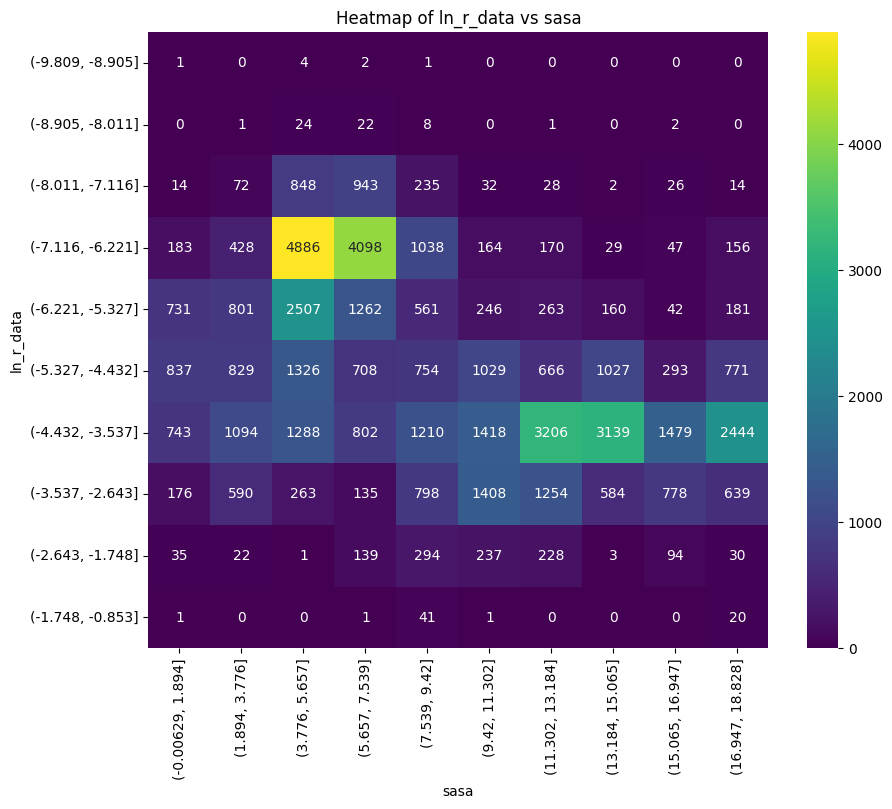

In [ ]:
create_heatmap(df_merge, 'ln_r_data', 'sasa', bins=10)

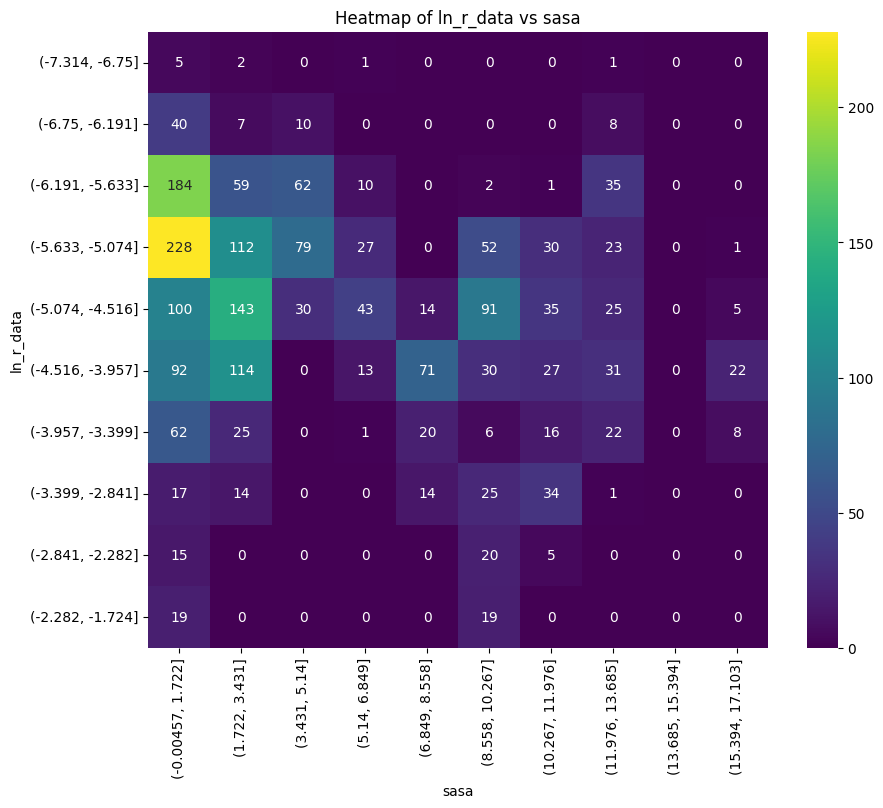

In [ ]:
df_sub = df_merge.query("r_type == 'NON-WC' and m_token == '1x1'").copy()
create_heatmap(df_sub, 'ln_r_data', 'sasa', bins=10)

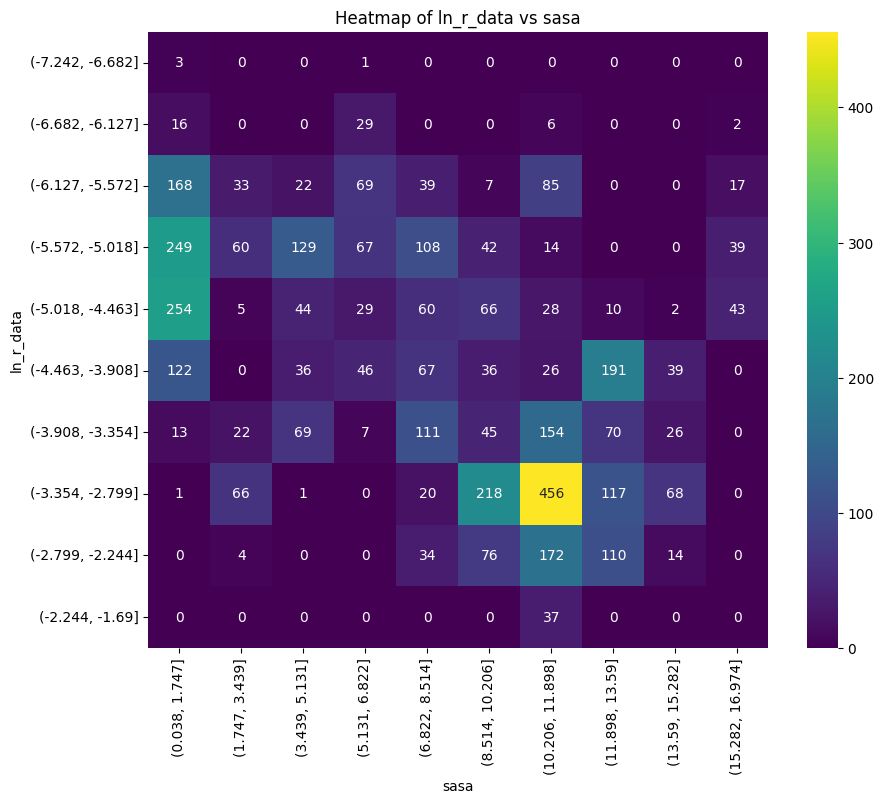

In [ ]:
df_sub = df_merge.query("r_type == 'NON-WC' and m_token == '2x2'").copy()
create_heatmap(df_sub, 'ln_r_data', 'sasa', bins=10)

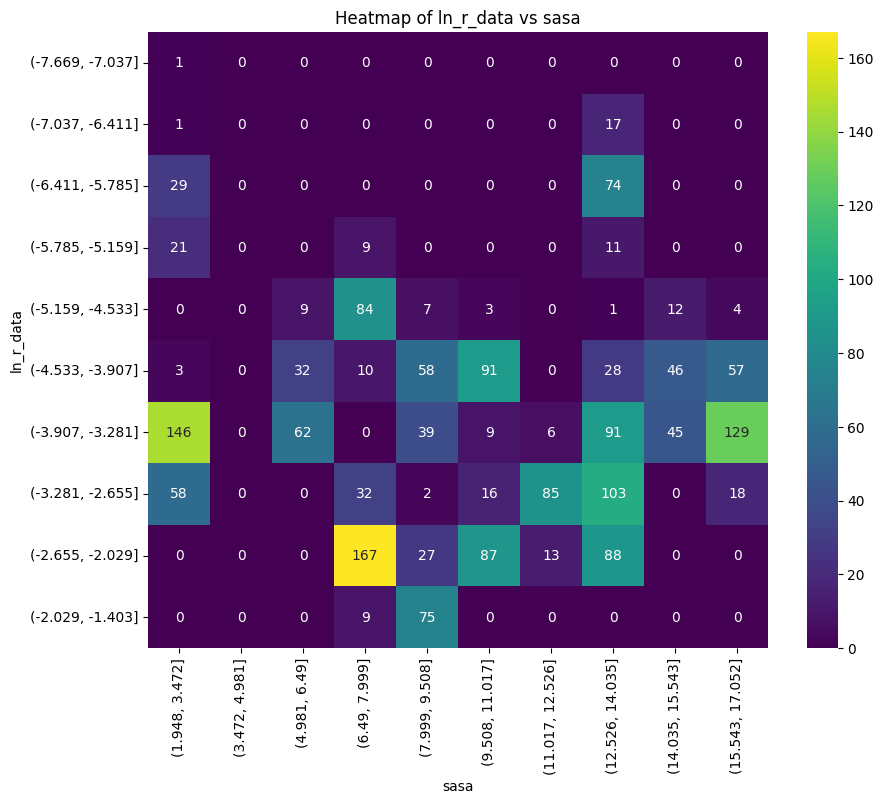

In [ ]:
df_sub = df_merge.query("r_type == 'NON-WC' and m_token == '3x3'").copy()
create_heatmap(df_sub, 'ln_r_data', 'sasa', bins=10)

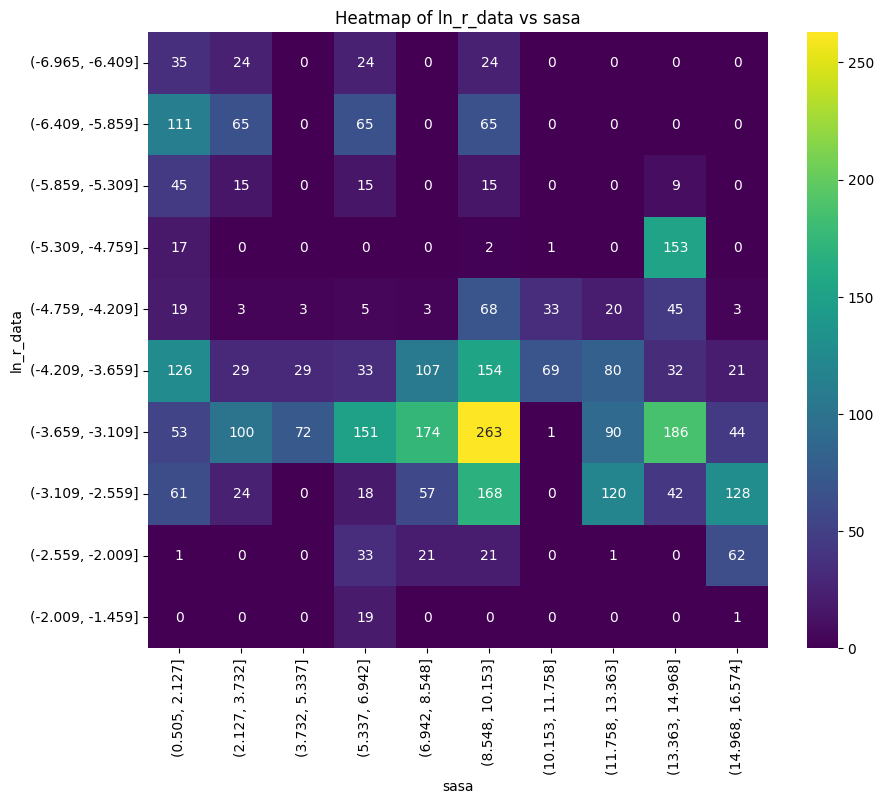

In [ ]:
df_sub = df_merge.query("r_type == 'NON-WC' and m_token == '4x4'").copy()
create_heatmap(df_sub, 'ln_r_data', 'sasa', bins=10)

<Axes: xlabel='sasa', ylabel='m_token'>

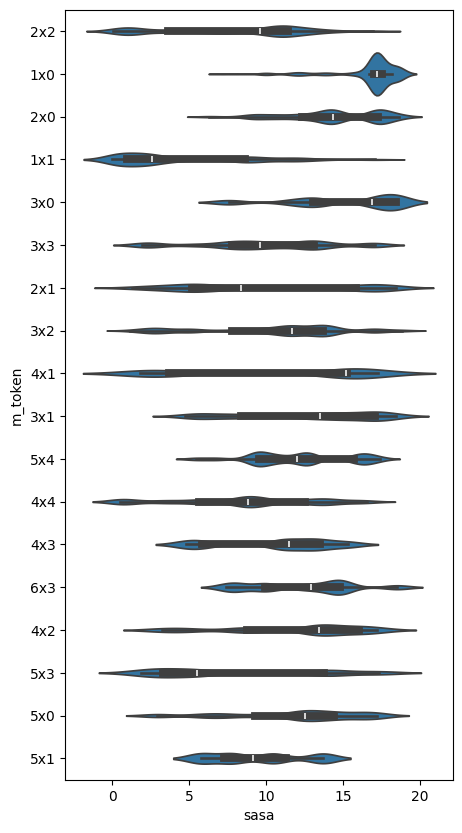

In [ ]:
fig, ax = plt.subplots(figsize=(5, 10))
sns.violinplot(data=df_non_wc, x="sasa", y="m_token", width=1.0, ax=ax)

<Axes: xlabel='sasa', ylabel='likely_pair'>

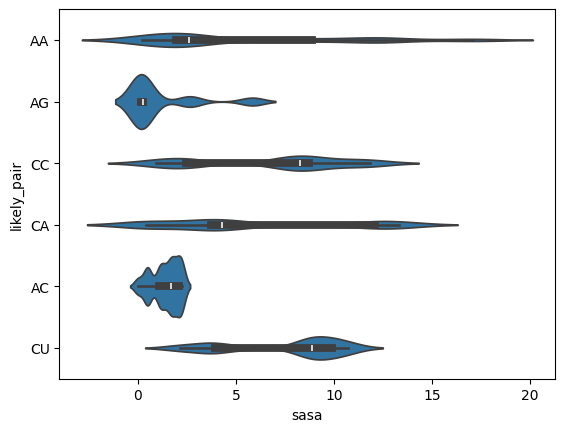

In [ ]:
df_sub = df_non_wc.query("m_token == '1x1'").copy()
sns.violinplot(data=df_sub, x="sasa", y="likely_pair", width=1.0)

<Axes: xlabel='ln_r_data', ylabel='likely_pair'>

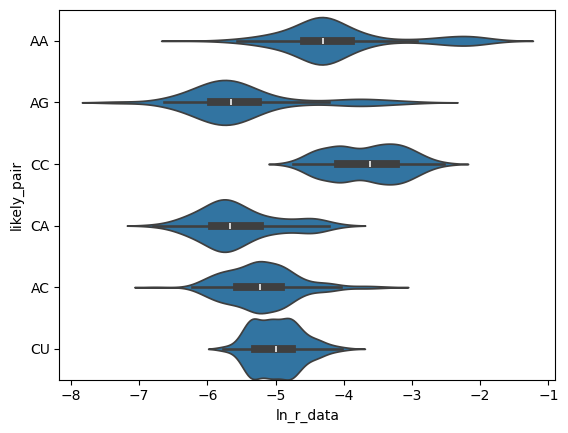

In [ ]:
df_sub = df_non_wc.query("m_token == '1x1'").copy()
sns.violinplot(data=df_sub, x="ln_r_data", y="likely_pair", width=1.0)

<Axes: xlabel='sasa', ylabel='likely_pair'>

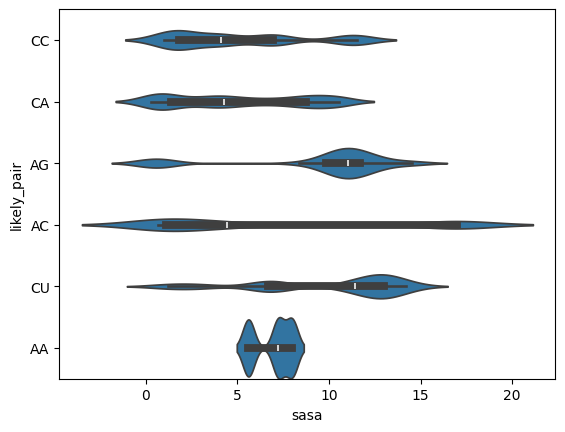

In [ ]:
df_sub = df_non_wc.query("m_token == '2x2'").copy()
sns.violinplot(data=df_sub, x="sasa", y="likely_pair", width=1.0)

<Axes: xlabel='ln_r_data', ylabel='likely_pair'>

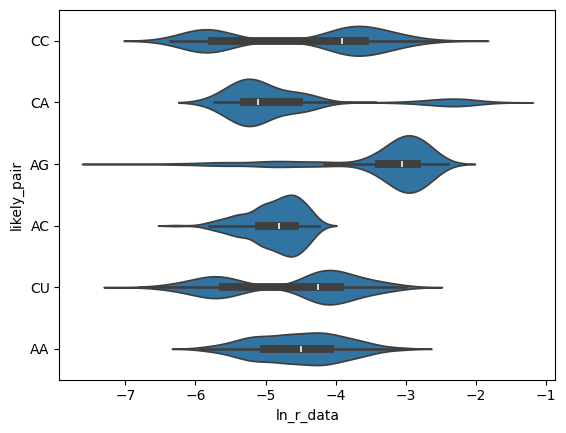

In [ ]:
df_sub = df_non_wc.query("m_token == '2x2'").copy()
sns.violinplot(data=df_sub, x="ln_r_data", y="likely_pair", width=1.0)

<Axes: xlabel='sasa', ylabel='likely_pair'>

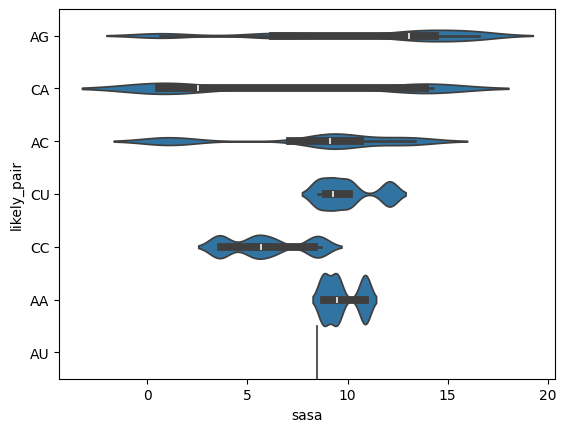

In [ ]:
df_sub = df_non_wc.query("m_token == '4x4'").copy()
sns.violinplot(data=df_sub, x="sasa", y="likely_pair", width=1.0)

<Axes: xlabel='ln_r_data', ylabel='likely_pair'>

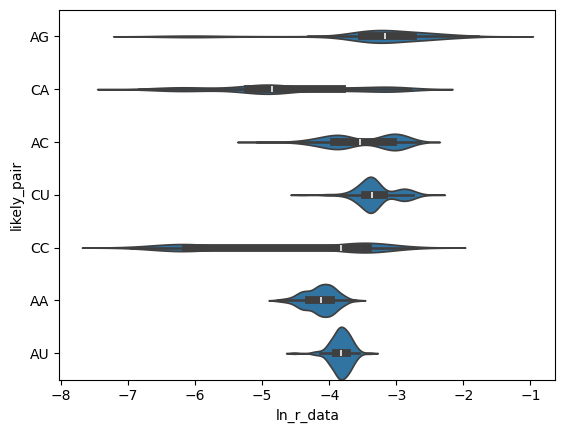

In [ ]:
df_sub = df_non_wc.query("m_token == '4x4'").copy()
sns.violinplot(data=df_sub, x="ln_r_data", y="likely_pair", width=1.0)